# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics as sts
import re
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer

Прочитаем файлы и запишем в переменные

In [2]:
df_train = pd.read_csv('main_task.csv') # основной датасет, используемый для построения признаков, нуждающийся в обработке
df_test = pd.read_csv('kaggle_task.csv') # тестовый датасет из 10 000 строк, в нем будем предсказывать целевую переменную
sample_submission = pd.read_csv('sample_submission.csv') # датасет из пробных предсказаний

In [3]:
df_train['Sample'] = 1 # создаем столбец-индикатор, помечаем где у нас тренировочный
df_test['Sample'] = 0 # помечаем где у нас тестовый
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем и переименуем столбцы
df.columns = ['Restaurant_id','City','Cuisine_Style','Ranking','Price_Range',
              'Number_of_Reviews','Reviews','URL_TA','ID_TA','Sample','Rating']
df.head()

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,Sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


Посмотрим на описание полученного датасета, какие признаки с пропусками, как и что будем заполнять и чистить

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine_Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price_Range        32639 non-null  object 
 5   Number_of_Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   Sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [5]:
print(type(df.Cuisine_Style[0]))
print(type(df.Reviews[0]))
display(df.Reviews[4574])
df.Price_Range.unique()

<class 'str'>
<class 'str'>


"[['Good Indian style cooking', 'Nice restaurant'], ['05/06/2017', '05/01/2017']]"

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

1. Видим пропуски в столбцах Cuisine_Style, Price_Range, Number_of_Reviews, Reviews
2. Видим, что числовыми являются лишь 4 признака, из которых 
    - Rating - целевая переменная
    - Sample - мыы добавили самостоятельно в качестве индикатора - т.е. она не будет участвовать в моделе.
3. Столбец Cuisine_Style - тип строковый, но выглядит как-будто список, нужно очищать.
4. Столбец Reviews - тип строковый, содержит отзывы и дату, можно вытащить необходимую информацию из данного признака и оцифровать.
5. City - это список городов, в которых расположены исследуемые рестораны. Можно сделать dummy-переменную на его основании
6. URL_TA - адрес на сайте (не увидел в нем полезности), ID_TA - идентификатор (не увидел в нем полезности), Restaurant_id - идентификатор (не увидел в нем полезности)
7. Price_Range - уровень цен ресторана 3 варианта - сделаем категориальный признак.
8. Ranking - Место в рейтинге ресторанов города - хороший признак сам по себе.

Вывод: Работаем с пропусками, чистим данные, строим новые переменные

In [6]:
# Заполним пропуски, почистим и приведем в нужный вид признак с типами кухонь:
df.Cuisine_Style.fillna("[Unknown]", inplace = True)
df.Cuisine_Style = df.Cuisine_Style.str[1:-1]
df.Cuisine_Style = df.Cuisine_Style.str.replace("'","")
df.Cuisine_Style = df.Cuisine_Style.str.split(',')

df2 = df.explode('Cuisine_Style')
df2.Cuisine_Style = df2.Cuisine_Style.str.strip()
print(df2.Cuisine_Style.value_counts().index[0]) # Самый популярный вид типа кухонь
# Посчитаем количество уникальных типов кухонь. Вычтем 1, которую мы обозначили как "Unknown"
print(df2.Cuisine_Style.nunique()-1)

Vegetarian Friendly
125


In [7]:
# Создадим новый признак Len_cuisine_style - он будет содержать сколько типов кухонь  том или ином ресторане
df['Len_cuisine_style'] = df.Cuisine_Style.apply(len)
df.Len_cuisine_style.mean() # посчитаем среднее

2.62532

In [8]:
# Заполним пропуски в признаке Number_of_Reviews средним значением для каждого города
dct_mean_num_rev = round(df.groupby(['City']).Number_of_Reviews.mean(),0).to_dict()
df.Number_of_Reviews.fillna(df.City.map(dct_mean_num_rev), inplace = True)

In [9]:
# Создадим новый числовой признак на основе категориального признака Price_Range
df['Price_Category'] = df.Price_Range.apply(lambda x: 1 if x=='$' else 2 if x=='$$ - $$$' else 3 if x=='$$$$' else x)
# Найдем среднее значение Price_Category для каждого города 
pd_Price_Category = pd.DataFrame(round(df.groupby(['City']).Price_Category.mean(),0))
display(pd_Price_Category) # Видим, что в среднем для каждого города показатель = 2
df.Price_Category.fillna(2, inplace=True) # Заполним пропуски соответственно
df.Price_Range.fillna('$$ - $$$', inplace=True) # Заполним пропуски и в этом признаке

,Price_Category
City,
Amsterdam,2.0
Athens,2.0
Barcelona,2.0
Berlin,2.0
Bratislava,2.0
Brussels,2.0
Budapest,2.0
Copenhagen,2.0
Dublin,2.0


In [10]:
#Заполним пропуски в признаке Reviews 
df.Reviews.fillna('[[], []]',inplace = True)

In [11]:
df.info()
# Пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine_Style      50000 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price_Range        50000 non-null  object 
 5   Number_of_Reviews  50000 non-null  float64
 6   Reviews            50000 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   Sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  Len_cuisine_style  50000 non-null  int64  
 12  Price_Category     50000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 5.0+ MB


Построим матрицу корреляций и посмотрим визуализацию некоторых признаков

In [12]:
df.corr()
# пока что с рейтингом коррелируется все не очень хорошо
# не учитывая Sample (мы ее создали сами для других целей), наиболее всего из таблицы с Rating коррелируется Ranking

,Ranking,Number_of_Reviews,Sample,Rating,Len_cuisine_style,Price_Category
Ranking,1.000000,-0.211920,0.006271,-0.109897,-0.322408,-0.026334
Number_of_Reviews,-0.211920,1.000000,0.002406,0.011489,0.394180,0.112183
Sample,0.006271,0.002406,1.000000,0.936543,-0.003202,-0.003419
Rating,-0.109897,0.011489,0.936543,1.000000,0.034506,-0.012176
Len_cuisine_style,-0.322408,0.394180,-0.003202,0.034506,1.000000,0.002816
Price_Category,-0.026334,0.112183,-0.003419,-0.012176,0.002816,1.000000


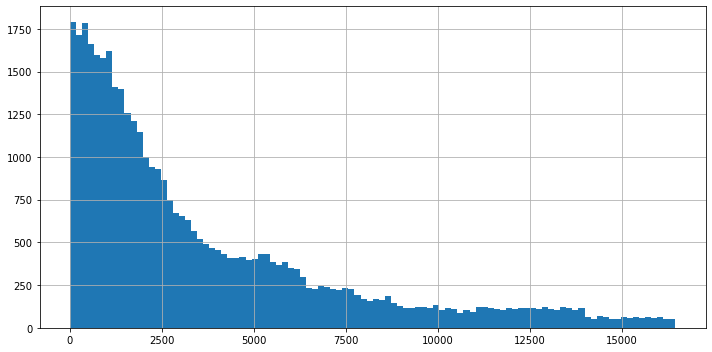

In [13]:
# Гистограмма переменной Ranking 
df[df.Sample == 1].Ranking.hist(figsize=(10, 5), bins=100)
plt.tight_layout()

In [14]:
print(df[(df.Sample == 1) & (df.Ranking > 2300)].Sample.value_counts())
print(df[(df.Sample == 1) & (df.Ranking <= 2300)].Sample.value_counts())

1    19906
Name: Sample, dtype: int64
1    20094
Name: Sample, dtype: int64


Мы видим, что примерно половина ресторанов имеет Ranking <= 2300 и там распределение "густое"

А другая половина больше и там распределение более размеренное

Посмотрим подробнее распределение признака Ranking для ТОП-10 городов по количеству представленных ресторанов

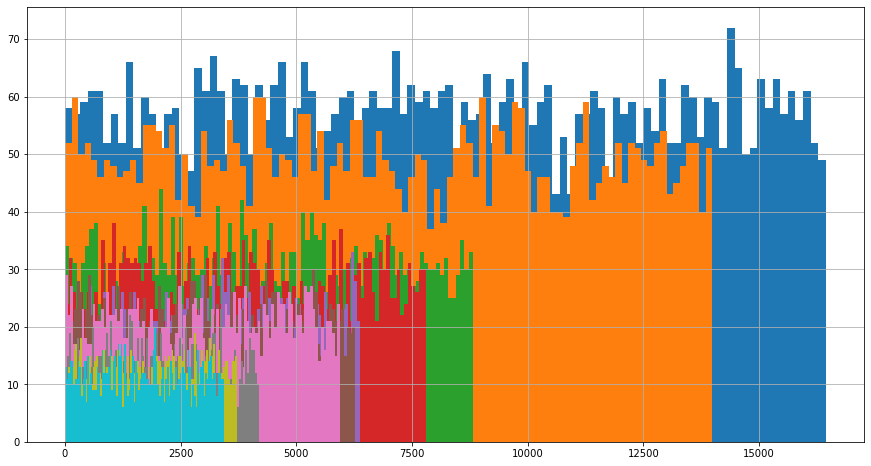

In [15]:
for x in (df[df.Sample == 1]['City'].value_counts())[0:10].index:
    df[df.Sample == 1].Ranking[df[df.Sample == 1].City == x].hist(figsize=(15, 8),bins=100)
plt.show()

Примерно видим, что признак распределен нормально для каждого города, только где-то ресторанов больше, где-то меньше по количеству.

Создадим еще несколько признаков:
 - Count_Rest_City - количество ресторанов в городе
 - Population - население в городе
 - Rest_for_people - сколько человек на 1 ресторан в млн.
 - Days_Reviews - содержит количество дней, которое отделяет даты публикации отзывов, размещённых на сайте ресторана
 - Chain - является ресторан сетевым или нет, значения 0 или 1
 - Vegan - присутствует ли вегетарианская кухня в ресторане, значения 0 или 1
 - Top_Tourism - входит ли город ТОП-10 самыйх посещяемых городов Европы, согласно Tripadvisor. Значения 0 или 1
 - Good_rev - поищем "хорошие" слова в отзывах и если они есть, то ставим ресторану кол-во встреченных слов, если нет, то 0
 - 2 dummy-переменные на основе признаков Города (City) и Виды Кухонь (Cuisine_Style)

In [16]:
dct_count_city = df.City.value_counts().to_dict() # словарь, собирающий кол-во ресторанов в городе
df['Count_Rest_City'] = df.City.map(dct_count_city) # создаем признак

In [17]:
# словарь из количества жителей в каждом городе
dct_population = {'London': 8.173900,
    'Paris': 2.240621,
    'Madrid': 3.155360,
    'Barcelona': 1.593075,
    'Berlin': 3.326002,
    'Milan': 1.331586,
    'Rome': 2.870493,
    'Prague': 1.272690,
    'Lisbon': .547733,
    'Vienna': 1.765649,
    'Amsterdam': .825080,
    'Brussels': .144784,
    'Hamburg': 1.718187,
    'Munich': 1.364920,
    'Lyon': .496343,
    'Stockholm': 1.981263,
    'Budapest': 1.744665,
    'Warsaw': 1.720398,
    'Dublin': .506211 ,
    'Copenhagen': 1.246611,
    'Athens': 3.168846,
    'Edinburgh': .476100,
    'Zurich': .402275,
    'Oporto': .221800,
    'Geneva': .196150,
    'Krakow': .756183,
    'Oslo': .673469,
    'Helsinki': .574579,
    'Bratislava': .413192,
    'Luxembourg': .576249,
    'Ljubljana': .277554
    }
df['Population'] = df.City.map(dct_population) # признак на основе словаря

In [18]:
# сколько человек на 1 ресторан в млн
df['Rest_for_people'] = df.Population/df.Count_Rest_City

In [19]:
# Как часто в городе оставляют отзывы
df['NR_P'] = df['Number_of_Reviews'] / df['Population']

In [20]:
df3 = df.copy()
# с помощью модуля re найдем даты в признаке Reviews и заполним этими датами новый временный признак Date 
pattern = re.compile('\d\d\W\d\d\W\d\d\d\d')
df3['Date'] = df.Reviews.apply(pattern.findall)
#df3.Date[2698].pop(0) # путем долгих поисков и ступора... находим ошибку в одной записи с датами и удаляем лишний элемент

# Как таковых пропусков в данном признаке не увидел 
# Но т.к. каждое значение это список, есть пустые списки или неполные, которые меня не устраивают
# Сделаем так, чтобы в каждой строке этого признака было 2 даты
for i in range(len(df3.Date)):
    if df3.Date[i] == []:
        df3.Date[i].append('21/04/2004')# Заполним эти пустые списки дат на самую старую дату, встречающущюся в датафрейме.
        df3.Date[i].append('21/04/2004')# Таких дат должно быть 2 в списке, при чем одинаковых, чтоб разница в днях потом была "0".
    elif len(df3.Date[i]) == 1:
        df3.Date[i].append(df3.Date[i][0]) # Если было только 1 значение даты (т.е. всего 1 комментарий) дополним его такой же датой
df3 = df3.explode('Date')
df3.Date = pd.to_datetime(df3.Date) # Меняем тип данных этого признака
df3.reset_index(drop = True, inplace = True)

# Создадим список, который будет хранить разницу в днях между первым и последним комментарием в этом ресторане.
lst_delta = []
for i in range(0,len(df3)-1,2):
    d0 = df3.Date[i]
    d1 = df3.Date[i+1]
    delta = abs(d0 - d1)
    lst_delta.append(delta.days)

# На основе списка добавим новый признак в исходный датафрейм:
df['Days_Reviews'] = lst_delta

In [21]:
# Создадим список id ресторанов, которые встречаются только 1 раз - предполагаем, что он не сетевой
count_rest = pd.DataFrame(df.Restaurant_id.value_counts())
count_rest_id = count_rest[count_rest.Restaurant_id == 1]
lst_count_id = count_rest_id.index.to_list()

df['Chain'] = [i for i in range(len(df))] # создаем столбец

# Заполним столбец значениями 0 и 1.  
# 0 - там, где значение id ресторана попдает в список, созданный выше
# Остальные значения 1, т.е. рестораны сетевые
for i in range(len(df)):
    if df.Restaurant_id[i] in lst_count_id:
        df['Chain'][i] = 0
    else:
        df['Chain'][i] = 1

<ipython-input-21-105746268443>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Chain'][i] = 1
<ipython-input-21-105746268443>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Chain'][i] = 0


In [22]:
# Создадим признак Vegan, который делит все заведения на вегетарианские и нет.
df['Vegan'] = [i for i in range(len(df))] # создаем столбец
for i in range(len(df)):
    if ' Vegetarian Friendly' in df.Cuisine_Style[i] or ' Vegan Options' in df.Cuisine_Style[i]:
        df['Vegan'][i] = 1
    else:
        df['Vegan'][i] = 0

<ipython-input-22-f174ae76765a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vegan'][i] = 0
<ipython-input-22-f174ae76765a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vegan'][i] = 1


In [23]:
# Создадим признак Top_Tourism, который показывает входит или нет тот или иной город в ТОП-10 туристических городов Европы.
# Список таких городов lst_top_tourism:
lst_top_tourism = ['Paris', 'London', 'Rome', 'Barcelona', 'Lisbon', 
                   'Edinburgh', 'Amsterdam', 'Madrid', 'Prague', 'Budapest']

#Заполним признак 1, если попадаем в список и 0, если не входит
df['Top_Tourism'] = [i for i in range(len(df))]
for i in range(len(df)):
    if df.City[i] in lst_top_tourism:
        df.Top_Tourism[i] = 1
    else:
        df.Top_Tourism[i] = 0

<ipython-input-23-25d29a7c2e38>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Top_Tourism[i] = 1
<ipython-input-23-25d29a7c2e38>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Top_Tourism[i] = 0


In [24]:
# Опишем функцию, которая по заданному списку будет искать слова в строках и возвращать 1 или 0. 
# 1 если есть такие слова (хотя бы одно) или 0 - если нет
def find_good_words(s):
    good_words = ['good', 'yummy', 'fine', 'great', 'tasty', 
                  'satisfaction', 'amazing', 'nice', 'best', 
                  'friendly', 'pleasant', 'exellent', 'loved', 
                  'love', 'lovely', 'welcoming', 'wonderful', 
                  'perfect', 'delicious', 'favourite', 'sweet',
                  'yum', 'adequate', 'happy', 'beautiful', 'liked', 'like']
    count = 0
    for item in good_words:
        if item in s:
            count += 1
    if count >= 1:
        result = 1
    else:
        result = 0
    return(result)
df['Good_rev'] = df.Reviews.str.lower().apply(find_good_words) # применим описанную функцию для создания нового признака
df['Good_rev'].value_counts()

1    30362
0    19638
Name: Good_rev, dtype: int64

До создания dummy-переменных посмотрим на матрицу корреляций для наших признаков 

In [25]:
df.corr()

,Ranking,Number_of_Reviews,Sample,Rating,Len_cuisine_style,Price_Category,Count_Rest_City,Population,Rest_for_people,NR_P,Days_Reviews,Chain,Vegan,Top_Tourism,Good_rev
Ranking,1.000000,-0.211920,0.006271,-0.109897,-0.322408,-0.026334,0.709012,0.566242,-0.136359,-0.183734,0.046817,-0.502592,-0.298465,0.449784,-0.157483
Number_of_Reviews,-0.211920,1.000000,0.002406,0.011489,0.394180,0.112183,0.026593,0.023097,-0.026054,0.552221,-0.055327,0.059105,0.358277,0.086186,0.114226
Sample,0.006271,0.002406,1.000000,0.936543,-0.003202,-0.003419,0.004595,0.003181,-0.000018,-0.003747,0.293595,0.079858,-0.002079,0.005681,0.000860
Rating,-0.109897,0.011489,0.936543,1.000000,0.034506,-0.012176,-0.014779,-0.003682,0.018858,0.002867,0.270277,0.150831,0.037951,-0.000546,0.041740
Len_cuisine_style,-0.322408,0.394180,-0.003202,0.034506,1.000000,0.002816,-0.024105,0.043610,0.043177,0.234117,-0.127197,0.092590,0.709128,0.047215,0.252116
Price_Category,-0.026334,0.112183,-0.003419,-0.012176,0.002816,1.000000,0.004841,-0.017237,-0.016404,0.059067,0.030659,0.005652,0.019982,-0.032869,-0.060082
Count_Rest_City,0.709012,0.026593,0.004595,-0.014779,-0.024105,0.004841,1.000000,0.797000,-0.193220,-0.150511,-0.028285,-0.309556,0.032135,0.637933,0.020040
Population,0.566242,0.023097,0.003181,-0.003682,0.043610,-0.017237,0.797000,1.000000,0.257452,-0.163241,-0.056526,-0.287099,0.087469,0.417555,0.056801
Rest_for_people,-0.136359,-0.026054,-0.000018,0.018858,0.043177,-0.016404,-0.193220,0.257452,1.000000,-0.121948,-0.032878,0.011778,0.040465,-0.289673,0.044543
NR_P,-0.183734,0.552221,-0.003747,0.002867,0.234117,0.059067,-0.150511,-0.163241,-0.121948,1.000000,-0.032658,0.045403,0.188024,-0.083868,0.065568


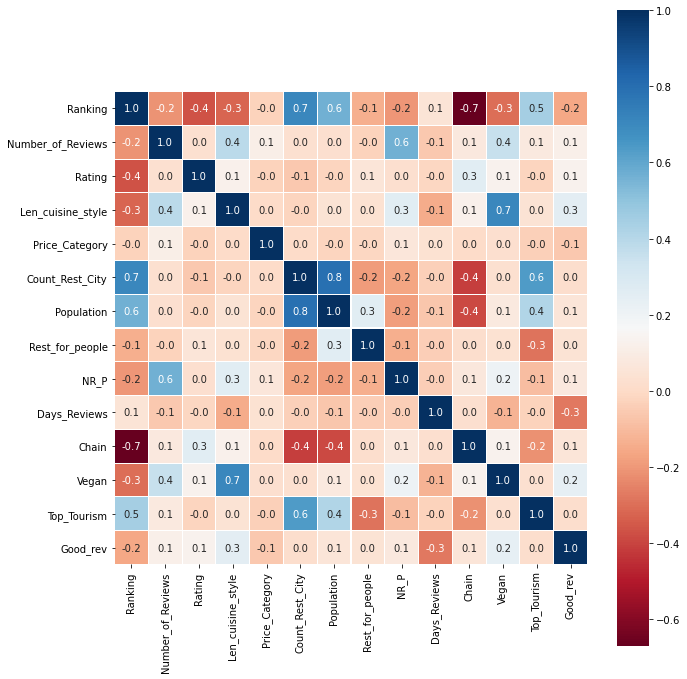

In [26]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(df[df.Sample == 1].drop(['Sample'], axis=1).corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

С рейтингом хоть как-то коррелируется Ranking и Chain - показатель сетевой ли ресторан или нет.
Остальные не особо.

Но можем заметить, что некоторые признаки скоррелированы достаточно неплохо. Плюс, скорее все, есть опосредованная корреляция


In [27]:
# Создадим dummy-переменную на основе переменной City
df_city = df.copy()
df_city_dummy = pd.get_dummies(df_city.City, drop_first=True)
df = pd.concat([df, df_city_dummy],axis=1) # добавим полученный датафрейм в наш основной

In [28]:
# Создадим dummy-переменную на основе переменной Cuisine_Style
mlb = MultiLabelBinarizer()
data_Cuisine_Style_MLB = pd.DataFrame(mlb.fit_transform(df["Cuisine_Style"]), columns=mlb.classes_)
df = df.join(data_Cuisine_Style_MLB)

In [29]:
dff = df.copy()

#Создадим список названий нечисловых столбцов

dff_non_num = dff.select_dtypes(exclude=[np.number])
non_num_cols = dff_non_num.columns.values

dff.drop(labels = non_num_cols, axis = 1, inplace = True)
#dff.head()

In [30]:
# Разделим датасет к изначальному виду: тренировочный и тестовый
train_data = dff.query('Sample == 1').drop(['Sample'], axis=1)
test_data = dff.query('Sample == 0').drop(['Sample'], axis=1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [31]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
y = train_data.Rating.values
X = train_data.drop(['Rating'], axis=1)

In [32]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [33]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [34]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [35]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)
y_pred = np.round(y_pred * 2) / 2

In [36]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1818


<AxesSubplot:>

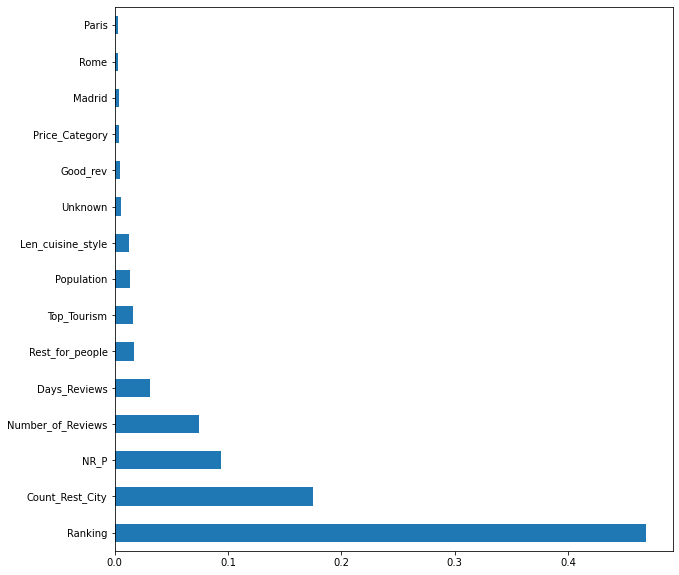

In [37]:
# Посмотрим на самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

А теперь подготовим файл submission для Kaggle, где предскажем рейтинг 10 000 ресторанов

In [38]:
test_data = test_data.drop(['Rating'], axis=1)

In [39]:
sample_submission # Посмотрим на тестовый файл

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [40]:
# Здесь предскажем рейтинг, округлив его до целого
predict_submission = np.round(regr.predict(test_data) * 2) / 2

In [41]:
predict_submission # Получили массив рейтингов

array([3. , 4. , 4.5, ..., 3. , 4.5, 4. ])

In [42]:
# Далее заполним предсказанным рейтингом целевую переменную в тестовом submission
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('my_first_submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
